In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
from dataclasses import replace
import json
from pathlib import Path
import pickle

import datasets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
from tqdm.auto import tqdm

from src.datasets.speech_equivalence import SpeechHiddenStateDataset
from src.analysis.state_space import StateSpaceAnalysisSpec, \
    prepare_state_trajectory, aggregate_state_trajectory
from src.analysis.trf import coefs_to_df
from src.datasets.speech_equivalence import SpeechEquivalenceDataset
from src.utils.timit import get_word_metadata

In [24]:
dataset = "timit-no_repeats"
state_space_name = "phoneme"

# base_model = "w2v2_8"
# model_class = "rnn_8-aniso2"
# model_name = "word_broad"

base_model = "w2v2_6"
model_class = "rnn_8-weightdecay0.01"
model_name = "biphone_pred"

model_dir = f"outputs/models/{dataset}/{base_model}/{model_class}/{model_name}_10frames"
output_dir = f"outputs/notebooks/{dataset}/{base_model}/{model_class}/{model_name}_10frames/state_space"
dataset_path = f"outputs/preprocessed_data/{dataset}"
equivalence_path = f"outputs/equivalence_datasets/{dataset}/{base_model}/{model_name}_10frames/equivalence.pkl"
hidden_states_path = f"outputs/hidden_states/{dataset}/{base_model}/hidden_states.pkl"
state_space_specs_path = f"outputs/state_space_specs/{dataset}/{base_model}/state_space_specs.pkl"
embeddings_path = f"outputs/model_embeddings/{dataset}/{base_model}/{model_class}/{model_name}_10frames/embeddings.npy"

subjects = ["EC196", "EC212", "EC260"]
# encoder_name = "word_broad-aniso2-w2v2_8"
encoder_name = "biphone_pred"
encoder_dirs = {subject: Path(f"outputs/encoders/{dataset}") / encoder_name / subject for subject in subjects}

metric = "cosine"

In [38]:
with open(embeddings_path, "rb") as f:
    model_representations: np.ndarray = np.load(f)
# with open(state_space_specs_path, "rb") as f:
#     state_space_spec: StateSpaceAnalysisSpec = torch.load(f)[state_space_name]
with open(hidden_states_path, "rb") as f:
    hidden_states: SpeechHiddenStateDataset = torch.load(f)
dataset = datasets.load_from_disk(dataset_path)
# assert state_space_spec.is_compatible_with(model_representations)

In [39]:
def compute_biphone_state_space(dataset: datasets.Dataset,
                                hidden_state_dataset: SpeechHiddenStateDataset,
                                ):
    frames_by_item = hidden_state_dataset.frames_by_item

    from collections import defaultdict
    frame_spans_by_biphone = defaultdict(list)
    cuts_df = []

    def process_item(item):
        # How many frames do we have stored for this item?
        start_frame, stop_frame = frames_by_item[item["idx"]]
        num_frames = stop_frame - start_frame

        compression_ratio = num_frames / len(item["input_values"])

        for word in item["word_phonemic_detail"]:
            if len(word) == 0:
                continue

            start_dummy = {"phone": "#", "start": word[0]["start"], "stop": word[0]["stop"]}
            end_dummy = {"phone": "#", "start": word[-1]["start"], "stop": word[-1]["stop"]}
            word = [start_dummy] + word + [end_dummy]
                                     
            for i, (p1, p2) in enumerate(zip(word, word[1:])):
                biphone_start_frame = start_frame + int(p1["start"] * compression_ratio)
                biphone_stop_frame = start_frame + int(p2["stop"] * compression_ratio)

                biphone_label = (p1["phone"], p2["phone"])
                instance_idx = len(frame_spans_by_biphone[biphone_label])
                frame_spans_by_biphone[biphone_label].append((biphone_start_frame, biphone_stop_frame))

                # add constituent phonemes to cuts
                cuts_df.append({
                    "label": biphone_label,
                    "instance_idx": instance_idx,
                    "level": "phoneme",
                    "description": p1["phone"],
                    "onset_frame_idx": start_frame + int(p1["start"] * compression_ratio),
                    "offset_frame_idx": start_frame + int(p1["stop"] * compression_ratio),
                    "item_idx": item["idx"],
                })
                cuts_df.append({
                    "label": biphone_label,
                    "instance_idx": instance_idx,
                    "level": "phoneme",
                    "description": p2["phone"],
                    "onset_frame_idx": start_frame + int(p2["start"] * compression_ratio),
                    "offset_frame_idx": start_frame + int(p2["stop"] * compression_ratio),
                    "item_idx": item["idx"],
                })

    dataset.map(process_item, batched=False)

    biphones = sorted(frame_spans_by_biphone.keys())
    return StateSpaceAnalysisSpec(
        total_num_frames=hidden_state_dataset.num_frames,
        labels=biphones,
        target_frame_spans = [frame_spans_by_biphone[b] for b in biphones],
        cuts=pd.DataFrame(cuts_df).set_index(["label", "instance_idx", "level"]).sort_index(),
    )


In [44]:
state_space_spec = compute_biphone_state_space(dataset, hidden_states)
# gc these guys now
dataset = None
hidden_states = None

Map:   0%|          | 0/5040 [00:00<?, ? examples/s]

In [45]:
assert state_space_spec.is_compatible_with(model_representations)

In [46]:
encoders = {subject: torch.load(encoder_dir / "model.pkl") for subject, encoder_dir in encoder_dirs.items()}
electrode_df = pd.concat([pd.read_csv(encoder_dir / "electrodes.csv", index_col="electrode_idx") for encoder_dir in encoder_dirs.values()],
                         keys=subjects, names=["subject", "electrode_idx"])

In [47]:
coefs, model_embedding_coefs = {}, {}
electrode_names = {}
coef_dfs = {}
for subject, encoder_dir in tqdm(encoder_dirs.items()):
    num_fit_electrodes = encoders[subject].coef_.shape[0]
    electrode_names[subject] = electrode_df.loc[subject].head(num_fit_electrodes).electrode_name

    coefs_i = np.stack(torch.load(encoder_dir / "coefs.pkl"))
    coefs[subject] = coefs_i
    model_embedding_coefs[subject] = coefs_i[:, :, [idx for idx, name in enumerate(encoders[subject].feature_names)
                                                    if name.startswith("model_embedding")]]

    coef_dfs[subject] = coefs_to_df(coefs_i, encoders[subject].feature_names,
                                    electrode_names[subject], encoders[subject].sfreq)

  0%|          | 0/3 [00:00<?, ?it/s]

## Embedding PCA analysis

In [48]:
len(state_space_spec.labels)

1179

In [54]:
trajectory = prepare_state_trajectory(
    model_representations,
    state_space_spec,
    pad=np.nan
)

In [55]:
trajectory = aggregate_state_trajectory(trajectory, "mean", keepdims=True)

In [56]:
all_trajectories_full = np.concatenate(trajectory)
all_trajectories_src = np.concatenate([
    np.stack([np.ones(traj_i.shape[0]) * idx, np.arange(traj_i.shape[0])]).T
    for idx, traj_i in enumerate(trajectory)
]).astype(int)

# flatten & retain non-padding
all_trajectories = all_trajectories_full.reshape(-1, all_trajectories_full.shape[-1])
retain_idxs = ~np.isnan(all_trajectories).any(axis=1)
all_trajectories = all_trajectories[retain_idxs]
all_trajectories_src = all_trajectories_src[retain_idxs]

all_trajectories_estimation = all_trajectories

# # for PCA estimation, retain only those words with at least `pca_min_freq`

# # retain just `pca_min_freq` instances of each word for PCA estimation, to make sure the space
# # is not biased for frequent words
# retain_idxs_estimation = []
# for label_idx in range(len(trajectory)):
#     traj_idxs = np.where(all_trajectories_src[:, 0] == label_idx)[0]
#     retain_idxs_estimation.append(np.random.choice(
#         traj_idxs, min(len(traj_idxs), pca_min_freq), replace=False))
# retain_idxs_estimation = np.concatenate(retain_idxs_estimation)
# all_trajectories_estimation = all_trajectories[retain_idxs_estimation]
# all_trajectories_src_estimation = all_trajectories_src[retain_idxs_estimation]

In [57]:
pca = PCA(n_components=4)
pca.fit(all_trajectories_estimation)

all_trajectories_pca = pca.transform(all_trajectories)

In [58]:
pca.explained_variance_ratio_

array([6.15095016e-01, 2.85740434e-01, 9.89211789e-02, 1.42573896e-04])

In [59]:
pca_coefs = {subject: pca.transform(model_coefs_i.transpose((0, 1, 3, 2)).reshape((-1, 8))) \
    .reshape(model_coefs_i.shape[:2] + (61, pca.n_components_)).transpose((0, 1, 3, 2))
    for subject, model_coefs_i in model_embedding_coefs.items()}
pca_coefs = {subject: pca_coefs_i - pca_coefs_i[:, :, :, :1] for subject, pca_coefs_i in pca_coefs.items()}
{subject: c.shape for subject, c in pca_coefs.items()}

{'EC196': (3, 256, 4, 61), 'EC212': (3, 384, 4, 61), 'EC260': (3, 256, 4, 61)}

In [60]:
pca_coef_df = pd.concat({
    subject: coefs_to_df(
        pca_coefs_i, [f"pca_{i}" for i in range(pca.n_components_)],
        electrode_names[subject], encoders[subject].sfreq)
    for subject, pca_coefs_i in pca_coefs.items()
    }, names=["subject"]).reset_index()
pca_coef_df["electrode_label"] = pca_coef_df.subject.str.cat(pca_coef_df.output_dim.astype(str), sep="_")

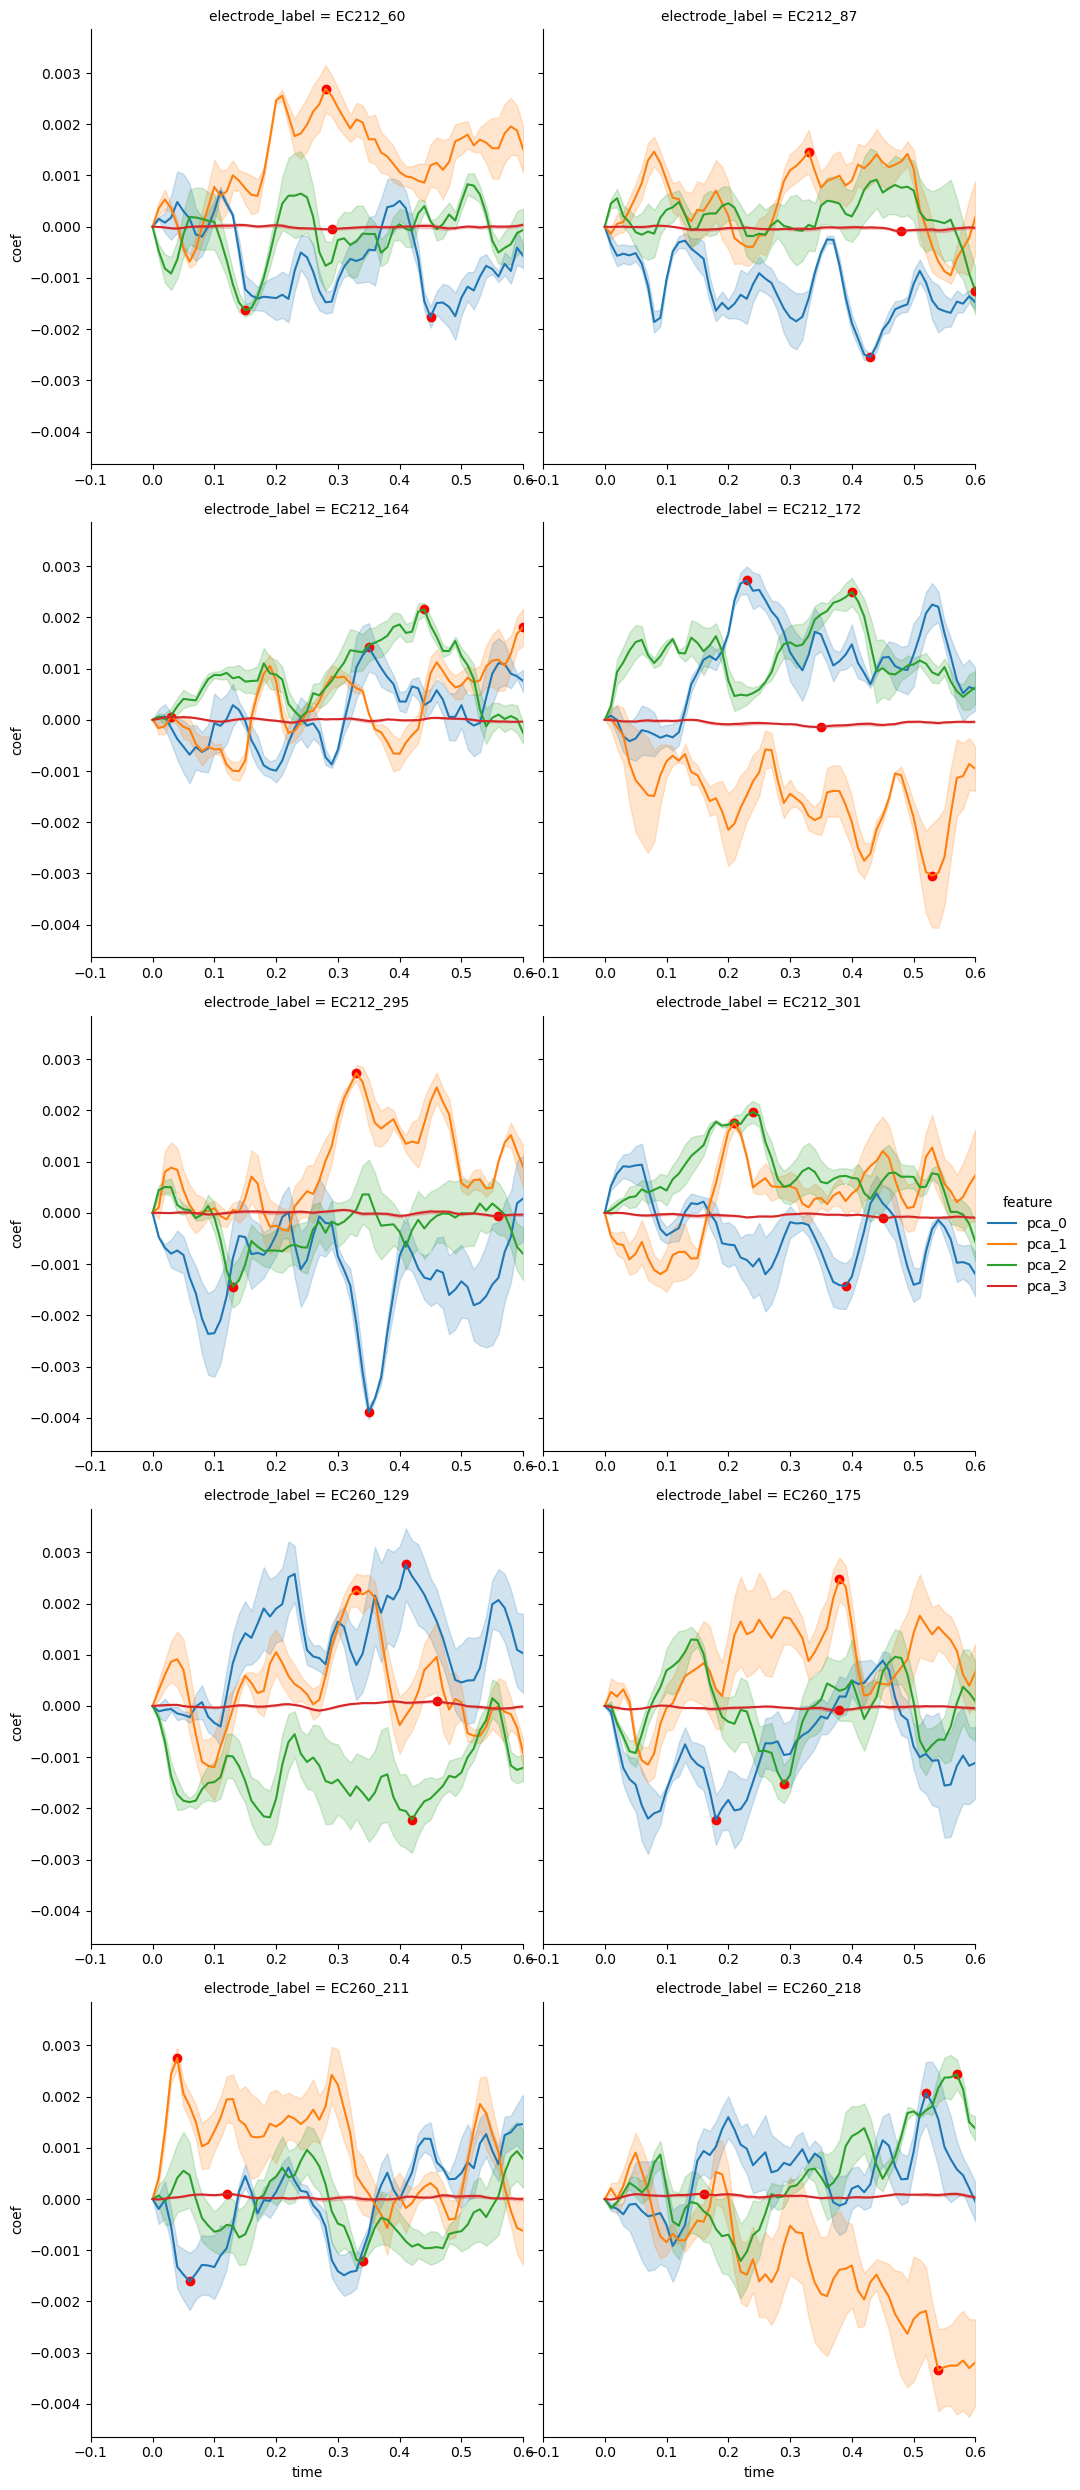

In [61]:
# plot word-dominant electrodes in PC space
# word_dominant = sorted([f"EC212_{dim}" for dim in [220, 214, 107, 74, 114, 211]] + \
#     [f"EC196_{dim}" for dim in [185, 233, 8]] + \
#     [f"EC260_{dim}" for dim in [3, 84, 92, 126, 208, 210, 216]])
# word-dominant according to estimation on timit-no_repeats
biphone_pred_dominant = \
    [f"EC212_{dim}" for dim in sorted([301, 87, 164, 295, 172, 60])] + \
    [f"EC260_{dim}" for dim in sorted([211, 175, 129, 218])]
hue_order = [f"pca_{i}" for i in range(pca.n_components_)]
col_order = biphone_pred_dominant
g = sns.relplot(data=pca_coef_df[pca_coef_df.electrode_label.isin(biphone_pred_dominant)],
                col="electrode_label", col_wrap=2, col_order=col_order,
                x="time", y="coef",
                hue="feature", hue_order=hue_order,
                kind="line", errorbar="se", facet_kws=dict(sharex=False))

max_points = {}
for (row, col, hue), facet_data in g.facet_data():
    ax = g.facet_axis(row, col)
    ax.set_xlim((-0.1, 0.6))

    for feature, feature_rows in facet_data.groupby("feature"):
        facet_means = feature_rows.groupby("time").coef.mean()
        max_point = np.abs(facet_means).idxmax()
        ax.scatter(max_point, facet_means.loc[max_point], color="red")

        output_dim = feature_rows.output_dim.iloc[0]
        max_points[output_dim, feature] = max_point

## Understand the PCs

In [62]:
all_trajectories_pca.shape

(200190, 4)

In [117]:
for traj_idx in all_trajectories_pca[:, 0].argsort()[:40]:
    label_idx, instance_idx = all_trajectories_src[traj_idx]
    print(state_space_spec.labels[label_idx], instance_idx, all_trajectories_pca[traj_idx, 0])

('S', '#') 1956 -2.1440516723490384
('S', '#') 1478 -2.0321896953839413
('Z', '#') 92 -2.0307899461149495
('S', '#') 2718 -2.0269113292955794
('Z', '#') 1009 -2.019560842052461
('Z', '#') 44 -2.0171063086114978
('S', '#') 1793 -2.0145949178695917
('S', '#') 444 -1.9955073371930414
('S', '#') 3011 -1.9773249539118887
('S', '#') 1916 -1.9763612104272332
('S', '#') 2521 -1.955913723199088
('S', '#') 88 -1.9460538627370594
('Z', '#') 267 -1.9430685917132462
('S', '#') 1663 -1.9398983831937757
('T', 'S') 474 -1.9365074663470159
('T', '#') 613 -1.9364607744253939
('S', '#') 1505 -1.933582082704648
('S', '#') 2304 -1.9332486737294936
('S', '#') 1606 -1.9316611032243851
('Z', 'T') 0 -1.9275416831174945
('S', 'T') 673 -1.9271978405879011
('S', 'T') 52 -1.9248400208516203
('S', '#') 1400 -1.9233498341388722
('T', '#') 124 -1.9232001892651298
('T', '#') 3314 -1.919982987094351
('CH', '#') 59 -1.9196347557615865
('Z', '#') 1417 -1.9177177923809285
('Z', '#') 192 -1.9172560480054393
('Z', '#') 32 -

In [118]:
for traj_idx in all_trajectories_pca[:, 0].argsort()[-20:]:
    label_idx, instance_idx = all_trajectories_src[traj_idx]
    print(state_space_spec.labels[label_idx], instance_idx, all_trajectories_pca[traj_idx, 0])

('#', 'AO') 577 2.3315554181024516
('W', 'AA') 118 2.3349508715223712
('AO', '#') 5 2.3377522608797907
('AW', '#') 168 2.3417123897572267
('AH', 'L') 284 2.3422093369056305
('AY', '#') 291 2.3456658847156104
('AA', 'AO') 0 2.347781238930633
('AA', 'L') 93 2.359900860172762
('#', 'AO') 292 2.360734162664142
('#', 'AA') 305 2.383574629632245
('R', 'AA') 141 2.3869452023906845
('AO', '#') 127 2.3923210325302975
('AY', '#') 282 2.4018321322443166
('#', 'AO') 508 2.4020328756314964
('AO', '#') 140 2.4078616063410676
('AO', '#') 60 2.4197368534070662
('#', 'AA') 395 2.4232379470040817
('AO', '#') 21 2.429766689230383
('AA', 'L') 69 2.443668483824386
('AA', 'L') 36 2.473031724899608


In [105]:
instance_df = pd.DataFrame(
    [(state_space_spec.labels[label_idx], instance_idx)
     for label_idx, instance_idx in all_trajectories_src],
    columns=["label", "instance_idx"]).set_index(["label", "instance_idx"])

In [119]:
vowels = {'AH', 'IH', 'EY', 'ER', 'EH', 'HH', 'UH', 'IY', 'AE',
          'AO', 'AA', 'OW', 'OY', 'AW', 'AY', 'UW'}
instance_df["has_vowel"] = instance_df.groupby(["label", "instance_idx"]).apply(lambda xs: bool(set(xs.name[0]) & vowels))
# instance_metadata["classifier_label"] = instance_metadata.onset_phoneme.isin(pca_1_onsets)
# cmap = sns.color_palette("tab10", n_colors=10)
# scatter_colors = [cmap[int(instance_metadata.loc[(state_space_spec.labels[label_idx], instance_idx), "classifier_label"].item())]
#                   for label_idx, instance_idx in all_trajectories_src]

In [108]:
instance_df = pd.merge(
    pd.DataFrame(all_trajectories_pca,
        columns=[f"pca_{dim + 1}" for dim in range(pca.n_components_)],
        index=pd.MultiIndex.from_tuples([(state_space_spec.labels[label_idx], instance_idx) for label_idx, instance_idx in all_trajectories_src], names=["label", "instance_idx"])),
    instance_df,
    left_index=True, right_index=True, how="left", validate="one_to_one")

In [110]:
instance_df

pca_1     pca_2     pca_3     pca_4  has_vowel
label    instance_idx                                                   
(#, AA)  0             1.163460 -0.117412 -0.002953 -0.016334       True
         1             1.889161 -0.379648  0.140857 -0.025684       True
         2             1.262562  0.630296  0.660571 -0.006404       True
         3             1.189161  0.237057 -0.318570 -0.003920       True
         4             1.696788 -0.097771  0.126078 -0.012591       True
...                         ...       ...       ...       ...        ...
(ZH, UW) 13           -0.165072  0.128852 -0.326310 -0.002416       True
(ZH, W)  0             0.224599 -0.228616 -0.151824  0.007952      False
         1            -0.440599 -0.251556 -0.119367 -0.001151      False
         2            -1.014602 -0.479195 -0.062535 -0.008267      False
(ZH, Y)  0            -0.769677 -0.199989 -0.128778 -0.002297      False

[200190 rows x 5 columns]

<Axes: xlabel='pca_1', ylabel='pca_2'>

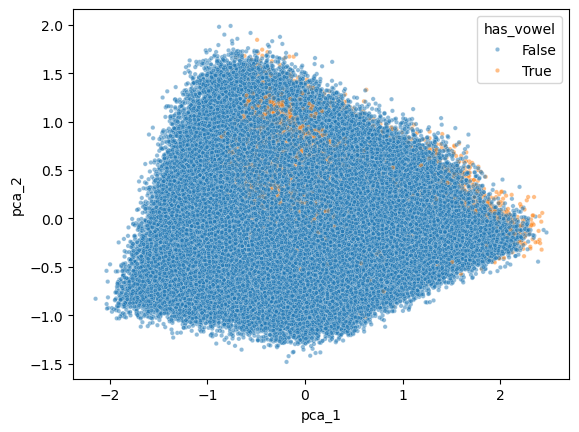

In [116]:
sns.scatterplot(data=instance_df, x="pca_1", y="pca_2", hue="has_vowel", s=10, alpha=0.5)

In [25]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, KFold

In [26]:
# from collections import Counter
# timit_dataset = datasets.load_from_disk("outputs/preprocessed_data/timit")
# repeat_texts = [text for text, _ in Counter(timit_dataset["text"]).most_common(2)]
# repeat_item_idxs = [idx for idx, text in enumerate(timit_dataset["text"]) if text in repeat_texts]
# # don't include repeat sentences in PCA evaluation
# train_df = instance_df.loc[~instance_df.index.get_level_values("item_idx").isin(repeat_item_idxs)]

In [27]:
# attempt to predict sonorant-ness of onset from PCA 1
X = train_df.pca_1.to_numpy()[:, None]
y = train_df.classifier_label

clf = LogisticRegressionCV(cv=KFold(5, shuffle=True), max_iter=1000)
clf.fit(X, y)
clf_scores = cross_val_score(clf, X, y, cv=KFold(5, shuffle=True), scoring="roc_auc")
print(clf_scores)
print(clf_scores.mean())

[0.96241079 0.95933625 0.95883115 0.96102752 0.96168016]
0.9606571754686828


In [28]:
train_df["log_word_frequency"] = np.log10(train_df.word_frequency)

In [29]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
# cross_val_score(LogisticRegressionCV(cv=KFold(5, shuffle=True)),
#                 train_df.pca_1.to_numpy()[:, None], (train_df.monosyllabic).to_numpy(),
#                 cv=KFold(5, shuffle=True), scoring="roc_auc")

cross_val_score(RidgeCV(cv=KFold(5, shuffle=True)),
                StandardScaler().fit_transform(train_df[["pca_2"]].to_numpy()),
                StandardScaler().fit_transform(train_df.log_word_frequency.to_numpy()[:, None])[:, 0],
                cv=KFold(5, shuffle=True))

array([0.19139147, 0.19479802, 0.16638911, 0.18583456, 0.17688931])

In [30]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
# cross_val_score(LogisticRegressionCV(cv=KFold(5, shuffle=True)),
#                 train_df.pca_1.to_numpy()[:, None], (train_df.monosyllabic).to_numpy(),
#                 cv=KFold(5, shuffle=True), scoring="roc_auc")

# explain variance in PC 2 from log word frequency
cross_val_score(RidgeCV(cv=KFold(5, shuffle=True)),
                StandardScaler().fit_transform(train_df.log_word_frequency.to_numpy()[:, None]),
                StandardScaler().fit_transform(train_df[["pca_2"]].to_numpy()),
                cv=KFold(5, shuffle=True))

array([0.18628832, 0.1704666 , 0.18613036, 0.19134561, 0.18140551])

In [31]:
# explain variance in PC 1 from sonorant-ish label
cross_val_score(RidgeCV(cv=KFold(5, shuffle=True)),
                train_df.classifier_label.astype(int).to_numpy()[:, None],
                StandardScaler().fit_transform(train_df.pca_1.to_numpy()[:, None])[:, 0],
                cv=KFold(5, shuffle=True)).mean()

0.6337418290439712

In [32]:
sample_pts = np.linspace(instance_df.pca_1.min(), instance_df.pca_1.max(), 100)
decision_boundary = sample_pts[((clf.predict_proba(sample_pts[:, None])[:, 0] - 0.5) ** 2).argmin()]
decision_boundary

-0.5554807998982993

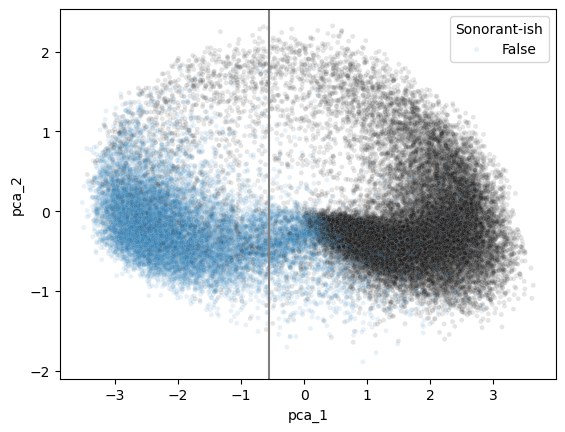

In [33]:
ax = sns.scatterplot(data=train_df.rename(columns={"classifier_label": "Sonorant-ish"}),
                     x="pca_1", y="pca_2", hue="Sonorant-ish", s=12, alpha=0.1)
ax.axvline(decision_boundary, color="gray")

<Axes: xlabel='word_frequency_quantile', ylabel='pca_2'>

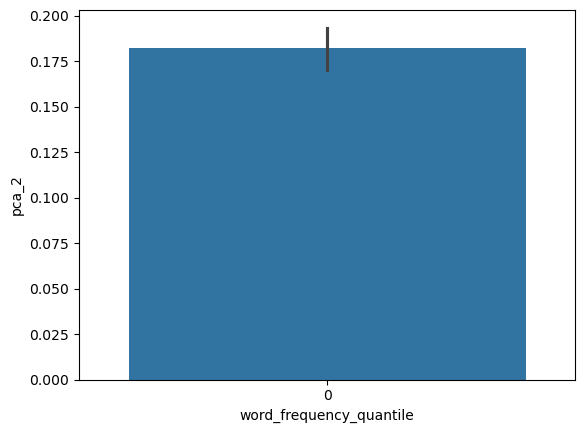

In [34]:
sns.barplot(data=train_df, x="word_frequency_quantile", y="pca_2")

In [35]:
train_df[train_df.pca_2.between(-0.5, 0.5)].sort_values("pca_1")

,,,pca_1,pca_2,pca_3,pca_4,num_syllables,monosyllabic,word_freq_lookup,word_frequency,word_frequency_quantile,onset_phoneme,onset_biphone,classifier_label,log_word_frequency
label,instance_idx,item_idx,,,,,,,,,,,,,
tapestry,2,1651,-3.515872,0.108317,0.060810,0.000165,3,False,tapestry,2.086527e+09,0,T,T EY,False,9.319424
porcupines,1,1767,-3.495362,-0.205342,0.080443,-0.009264,3,False,porcupines,2.086527e+08,0,P,P AO,False,8.319424
process,7,2885,-3.488780,0.311395,0.030177,0.030341,2,False,process,1.919257e+11,1,P,P R,False,11.283133
successors,0,1552,-3.440086,0.007375,0.065517,0.003558,3,False,successors,8.114271e+08,0,S,S IH,False,8.909250
questions,1,1506,-3.438512,-0.069697,0.011339,0.052382,2,False,questions,1.748973e+11,1,K,K W,False,11.242783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bayou,0,51,3.442400,-0.446833,-0.002269,0.032320,2,False,bayou,1.796732e+09,0,B,B AY,True,9.254483
oasis,6,4870,3.446794,-0.450217,0.002411,-0.024317,3,False,oasis,5.332235e+09,0,OW,OW EY,True,9.726909
lighted,1,3840,3.456459,-0.372353,0.026657,-0.046097,2,False,lighted,2.283588e+09,0,L,L AY,True,9.358618


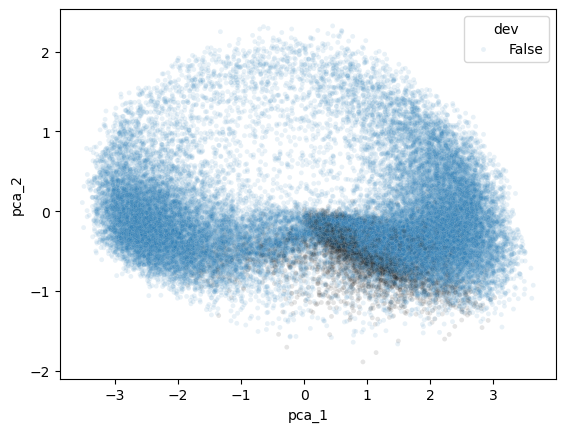

In [36]:
pca1_targets = ("don't", "did", "this", "didn't", "these", "do", "does", "it", "be",
                "then", "is", "he", "she", "get", "the", "into", "we", "a", "needs", "need",
                "used", "take", "use", "those", "took", "it's", "eat", "eating",
                "his", "can", "their", "any", "her", "got", "been", "could", "make", "makes",
                "come", "came", "they", "has")
train_df["dev"] = train_df.index.get_level_values("label").isin(
    pca1_targets)
ax = sns.scatterplot(data=train_df, x="pca_1", y="pca_2", hue="dev", s=12, alpha=0.1)

In [37]:
inspect = train_df.groupby("label").pca_2.agg(["mean", "std"]).sort_values("mean")
inspect = inspect[~inspect.index.isin(pca1_targets)]
inspect.head(20)

,mean,std
label,,
ghettos,-1.519661,NaN
establish,-1.483792,NaN
daydreamed,-1.470488,NaN
ingenuity,-1.453333,NaN
define,-1.411073,NaN
terrier,-1.409647,NaN
diet,-1.362923,NaN
addressed,-1.347471,NaN
together,-1.345647,0.140893


In [38]:
from scipy.stats import spearmanr, pearsonr
pearsonr(train_df.pca_2, train_df.log_word_frequency)

PearsonRResult(statistic=-0.4282595138622742, pvalue=0.0)

In [39]:
train_df[(~train_df.dev) & (train_df.pca_1 < 0)].sort_values("pca_2").head(20)

,,,pca_1,pca_2,pca_3,pca_4,num_syllables,monosyllabic,word_freq_lookup,word_frequency,word_frequency_quantile,onset_phoneme,onset_biphone,classifier_label,log_word_frequency,dev
label,instance_idx,item_idx,,,,,,,,,,,,,,
possessed,0,2481,-0.223000,-1.577355,0.031329,-0.050555,2,False,possessed,4.787420e+09,0,P,P AH,False,9.680102,False
thought,8,3688,-0.128919,-1.570651,0.039261,0.030766,1,True,thought,5.153374e+11,1,TH,TH AO,False,11.712092,False
dig,2,4449,-0.220341,-1.567555,-0.042058,-0.010831,2,False,dig,2.952436e+10,0,D,D IH,False,10.470180,False
die,1,745,-0.730423,-1.508253,-0.001799,-0.018042,1,True,die,1.171585e+11,1,D,D AY,False,11.068774,False
establish,0,4576,-0.598017,-1.483792,0.034326,-0.041794,3,False,establish,1.899899e+10,0,IH,IH S,True,10.278730,False
deadline,0,71,-0.382415,-1.457448,0.077728,-0.027594,2,False,deadline,3.268892e+10,0,D,D EH,False,10.514401,False
daphne's,2,4478,-0.924966,-1.427889,0.040959,-0.052514,2,False,daphne,1.680813e+09,0,D,D AE,False,9.225519,False
terrier,0,89,-0.581959,-1.409647,-0.079444,0.028936,3,False,terrier,1.935833e+09,0,T,T EH,False,9.286868,False
say,8,2930,-0.496181,-1.406319,0.089660,0.039303,1,True,say,1.007236e+12,1,EY,EY,True,12.003131,False


In [40]:
train_df.to_csv("20240510-train_df.csv")

In [41]:
instance_df["classifier_dec"] = clf.decision_function(instance_df.pca_1.to_numpy()[:, None])
instance_df['classifier_proba'] = clf.predict_proba(instance_df.pca_1.to_numpy()[:, None])[:, 0]
instance_df["classifier_output"] = instance_df.classifier_dec < 0

train_df["classifier_dec"] = clf.decision_function(train_df.pca_1.to_numpy()[:, None])
train_df['classifier_proba'] = clf.predict_proba(train_df.pca_1.to_numpy()[:, None])[:, 0]
train_df["classifier_output"] = train_df.classifier_dec < 0

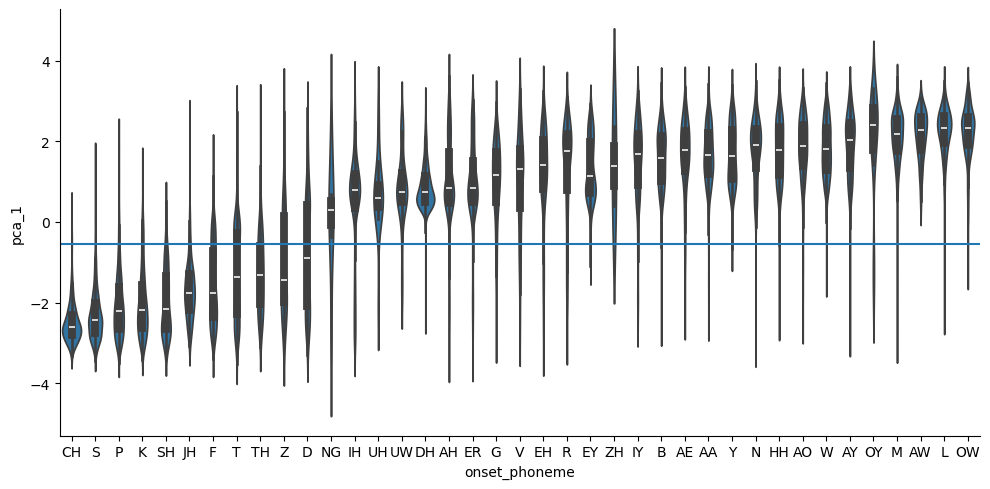

In [42]:
g = sns.catplot(data=train_df, x="onset_phoneme", y="pca_1", kind="violin",
                order=train_df.groupby("onset_phoneme").pca_1.mean().sort_values().index, aspect=2)
g.axes.flat[0].axhline(decision_boundary)

In [43]:
diverse_pca1 = train_df.groupby(["onset_phoneme"]).classifier_output.mean().sort_values()
diverse_pca1 = diverse_pca1[diverse_pca1.between(0.5 - 0.1, 0.5 + 0.1)]
diverse_pca1

onset_phoneme
D    0.550355
Name: classifier_output, dtype: float64

In [44]:
train_df.groupby("onset_phoneme").pca_1.agg(["mean", "std"]).sort_values("mean").dropna()

,mean,std
onset_phoneme,,
CH,-2.494743,0.503516
S,-2.310694,0.616404
P,-2.078830,0.775031
K,-2.007712,0.836243
SH,-1.975994,0.832906
JH,-1.675553,0.768098
F,-1.563490,0.960703
T,-1.275190,1.152152
TH,-1.259894,0.994941


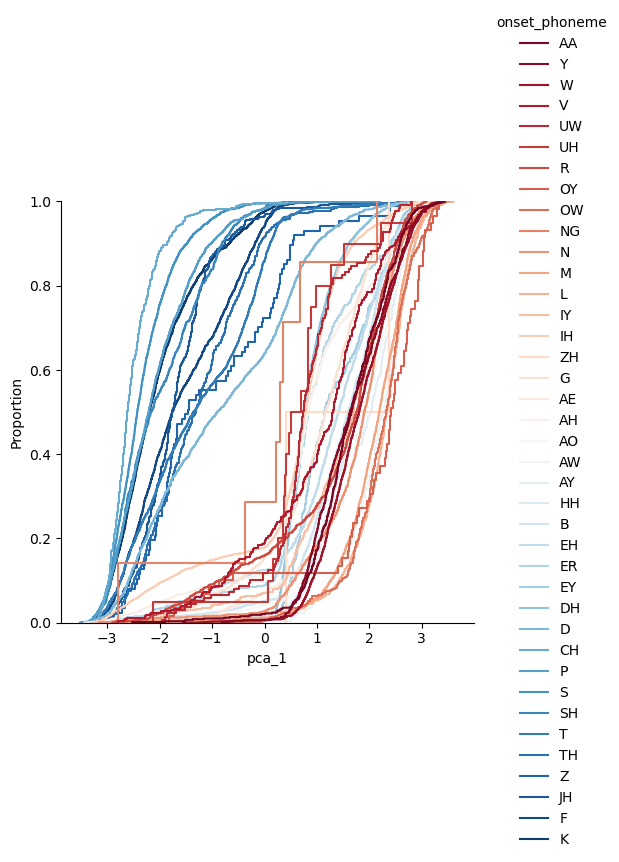

In [45]:
sns.displot(data=train_df, x="pca_1", hue="onset_phoneme", kind="ecdf",
            hue_order=train_df.groupby("onset_phoneme").classifier_output.median().sort_values().index,
            palette="RdBu")

In [46]:
train_df.loc["shoes"]

,,pca_1,pca_2,pca_3,pca_4,num_syllables,monosyllabic,word_freq_lookup,word_frequency,word_frequency_quantile,onset_phoneme,onset_biphone,classifier_label,log_word_frequency,dev,classifier_dec,classifier_proba,classifier_output
instance_idx,item_idx,,,,,,,,,,,,,,,,,
0,374,-1.155261,-0.130902,-0.055960,0.110166,1,True,shoes,8.470140e+10,1,UW,UW Z,True,10.927891,False,-0.949878,0.721091,True
1,421,-2.771002,-0.362397,0.026847,0.022932,1,True,shoes,8.470140e+10,1,SH,SH UW,False,10.927891,False,-3.635805,0.974314,True
2,436,-2.990441,-0.506568,0.019687,0.033759,1,True,shoes,8.470140e+10,1,SH,SH UW,False,10.927891,False,-4.000591,0.982024,True
3,798,-1.515098,-0.131565,0.018115,0.089330,1,True,shoes,8.470140e+10,1,UW,UW Z,True,10.927891,False,-1.548053,0.824632,True
4,1357,-2.261322,-0.376952,0.022164,0.016920,1,True,shoes,8.470140e+10,1,SH,SH UW,False,10.927891,False,-2.788539,0.942053,True
5,1574,-1.300665,-0.295193,-0.036439,0.096024,1,True,shoes,8.470140e+10,1,UW,UW Z,True,10.927891,False,-1.191590,0.767025,True
6,1718,-1.404691,-0.249612,-0.013917,0.087010,1,True,shoes,8.470140e+10,1,UW,UW Z,True,10.927891,False,-1.364519,0.796493,True
7,1742,-1.951027,-0.108735,-0.019475,0.058425,1,True,shoes,8.470140e+10,1,UW,UW Z,True,10.927891,False,-2.272720,0.906592,True
8,1757,-2.694951,-0.387818,0.051458,0.054263,1,True,shoes,8.470140e+10,1,SH,SH UW,False,10.927891,False,-3.509382,0.970954,True


## Model embedding projections

In [47]:
def plot_trajectory(output_dims, plot_type, trajectory_idxs=None, ax=None):
    if trajectory_idxs is None or isinstance(trajectory_idxs, int):
        trajectory_idxs = np.random.choice(all_trajectories_full.shape[0], size=trajectory_idxs, replace=False)

    assert len(output_dims) in [2, 3]
    assert output_dims == 2 or plot_type == "line", "need line plot if 3d"

    assert all_trajectories_full.shape[1] == 1
    plot_trajs = all_trajectories_full[trajectory_idxs, 0, :]

    # project into expected model activation space
    # TODO this isn't actually a fair rollout since we're ignoring other model features
    einsum_result = np.einsum("bd,fodt->fobt", plot_trajs, model_embedding_coefs)

    if ax is None:
        ax = plt.figure().add_subplot(projection='3d' if len(output_dims) == 3 else None)
    cmap = sns.color_palette("Set1", einsum_result.shape[2])
    for traj_idx in range(einsum_result.shape[2]):
        traj_label_idx, traj_instance = all_trajectories_src[trajectory_idxs[traj_idx]]
        traj_label = state_space_spec.labels[traj_label_idx]

        traj_data = einsum_result[:, output_dims][:, :, traj_idx, :].mean(axis=0).T
        # state_space_points = np.concatenate([np.zeros((1, 2)), traj_data], axis=0)
        state_space_points = traj_data

        if plot_type == "line":
            ax.plot(state_space_points[:, 0], state_space_points[:, 1],
                    marker="o" if traj_idx % 2 == 0 else "x",
                    label=traj_label, color=cmap[traj_idx], alpha=0.5)

            # mark starts
            ax.scatter(state_space_points[0, 0], state_space_points[0, 1],
                       marker="o" if traj_idx % 2 == 0 else "x", s=15)
        elif plot_type == "quiver":
            ax.quiver(state_space_points[:-1, 0], state_space_points[:-1, 1],
                      state_space_points[1:, 0] - state_space_points[:-1, 0],
                      state_space_points[1:, 1] - state_space_points[:-1, 1],
                      label=traj_label, alpha=0.5, color=cmap[traj_idx], scale=0.01)

    ax.set_xlabel(str(output_dims[0]))
    ax.set_ylabel(str(output_dims[1]))

    if len(trajectory_idxs) <= 20:
        ax.legend()
    return ax

ValueError: einstein sum subscripts string contains too many subscripts for operand 1

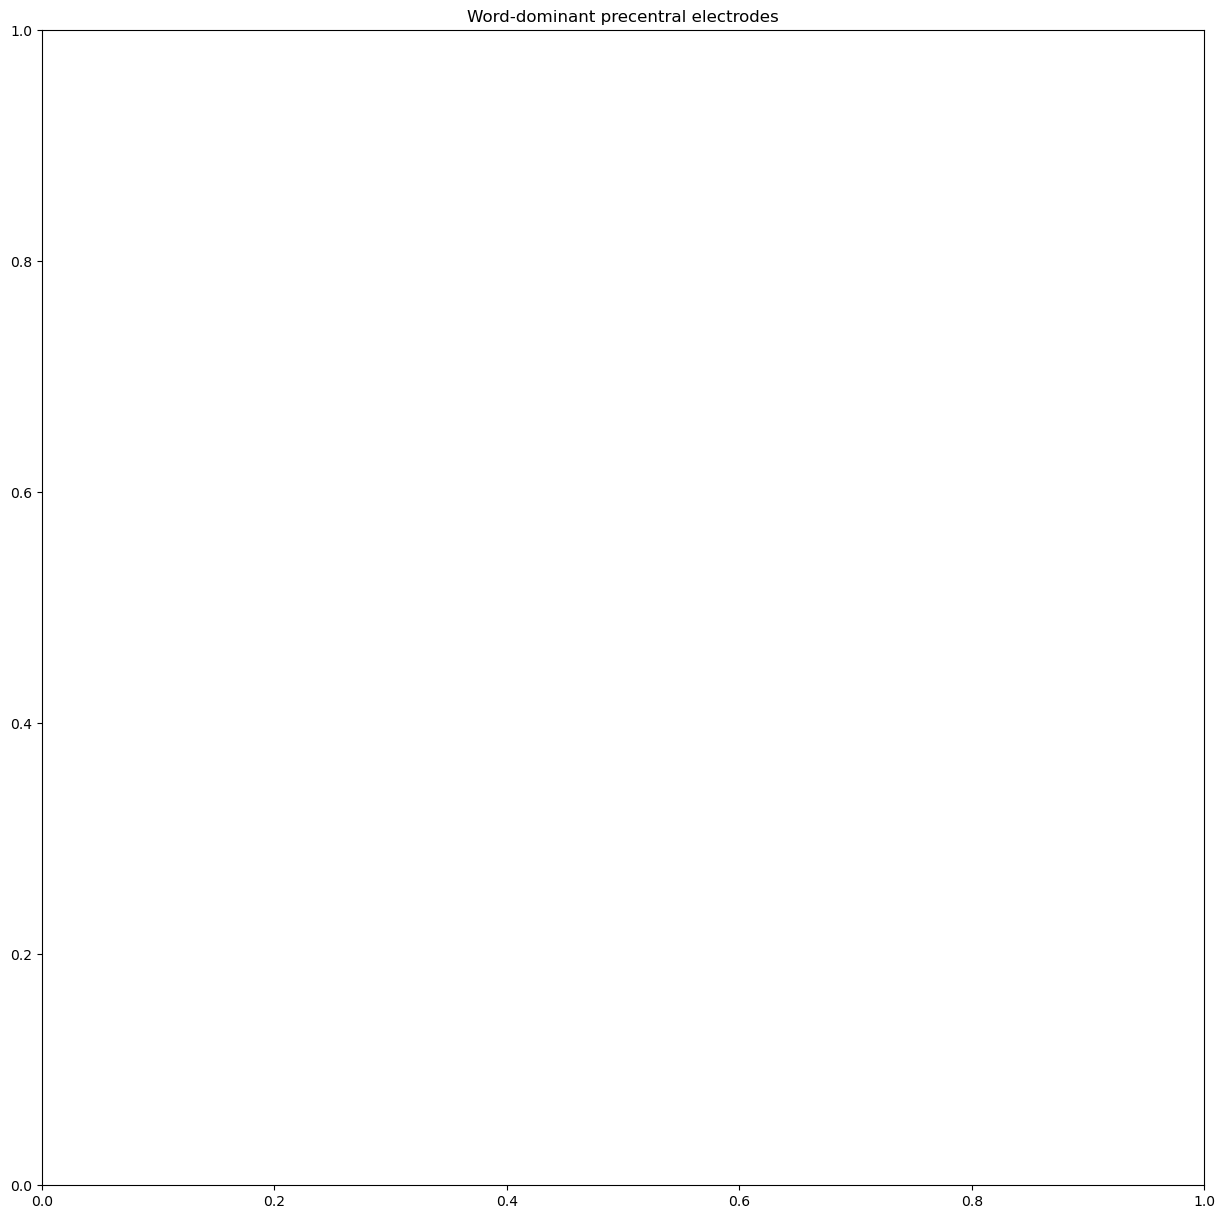

In [48]:
f, ax = plt.subplots(figsize=(15, 15))
ax.set_title("Word-dominant precentral electrodes")
plot_trajectory([57, 107], "line", 20, ax=ax)

<Axes: title={'center': 'Word-dominant STG electrodes'}, xlabel='214', ylabel='230'>

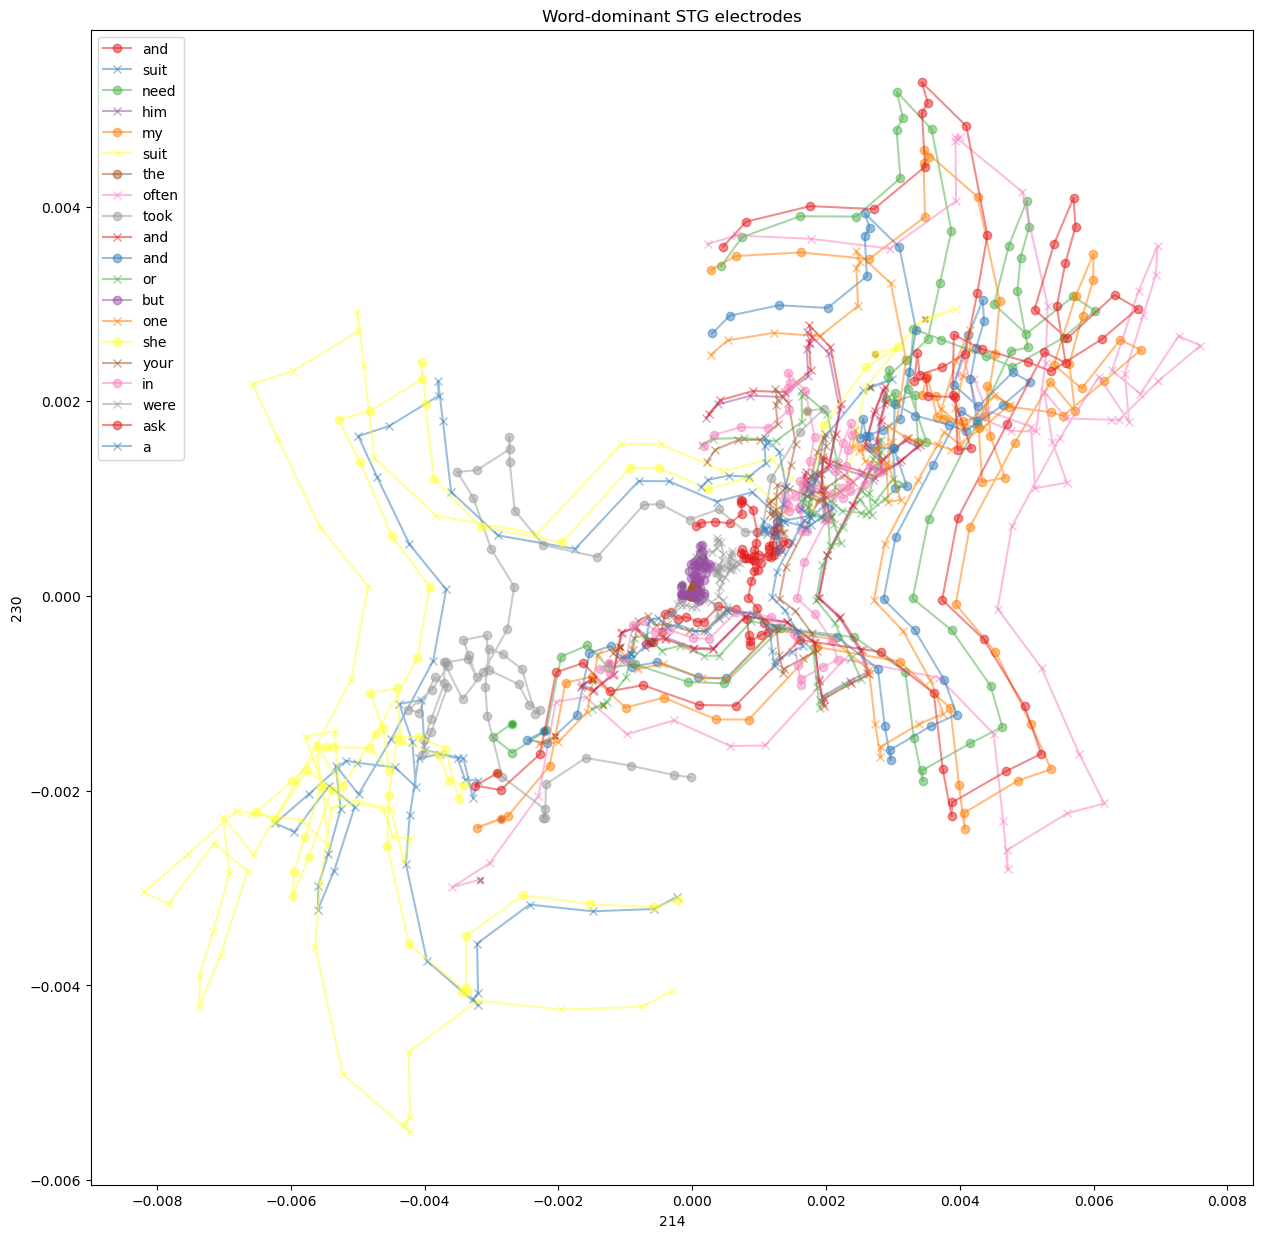

In [ ]:
ax = plt.subplots(figsize=(15, 15))[1]
ax.set_title("Word-dominant STG electrodes")
plot_trajectory([214, 230], "line", 20, ax=ax)

<Axes3D: title={'center': 'Word-dominant STG electrodes'}, xlabel='220', ylabel='214'>

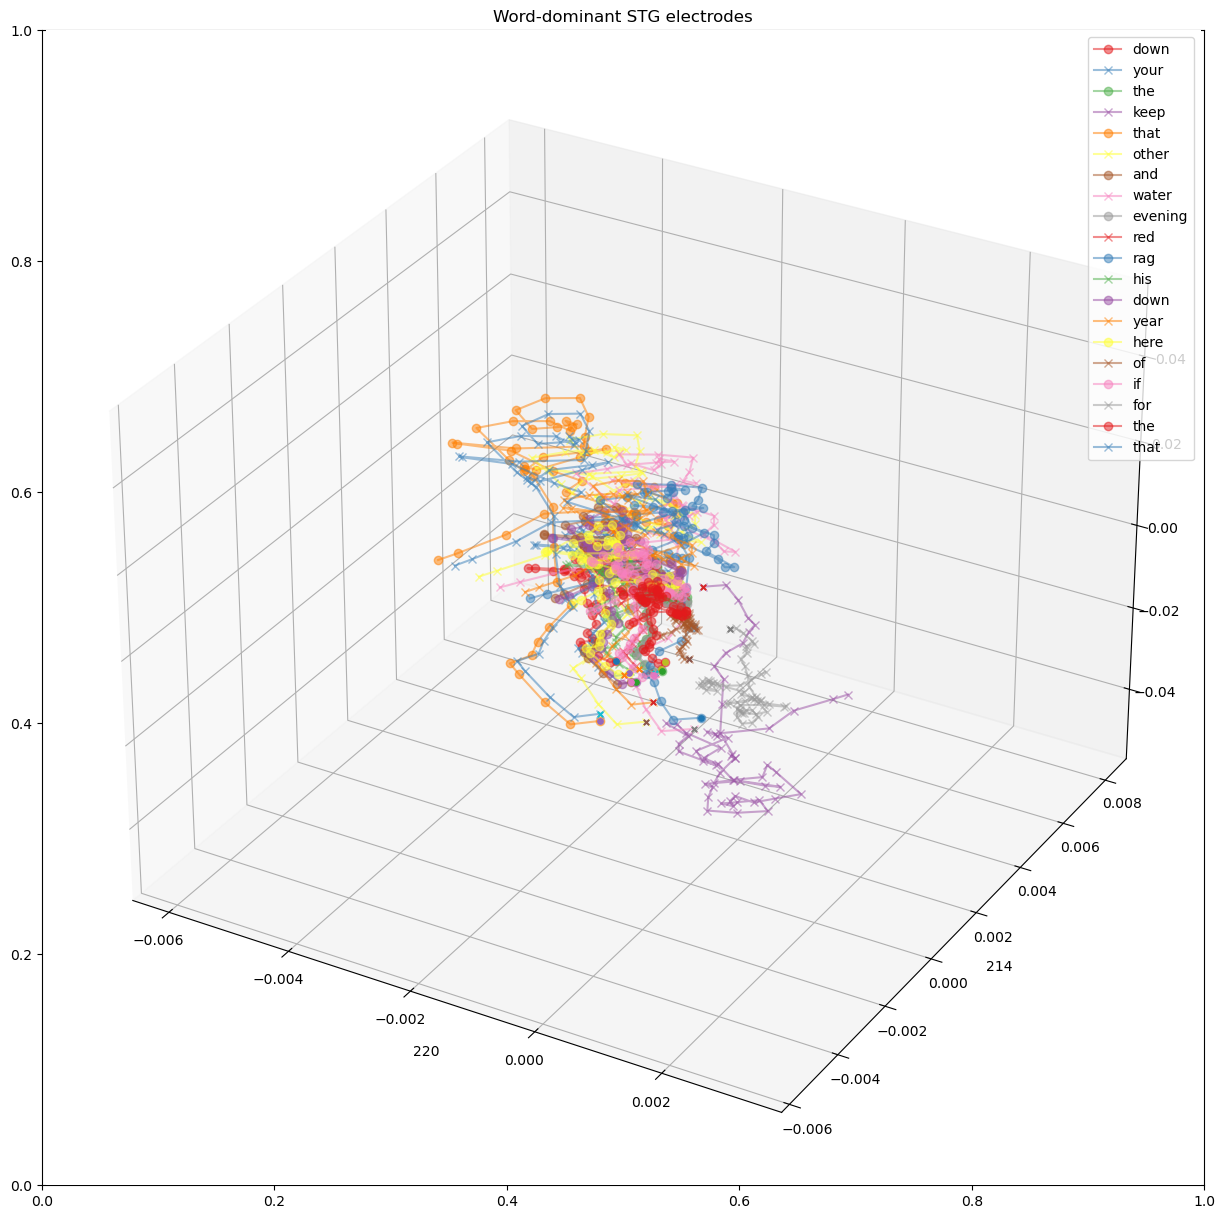

In [ ]:
ax = plt.subplots(figsize=(15, 15))[0].add_subplot(projection='3d')
ax.set_title("Word-dominant STG electrodes")
plot_trajectory([220, 214, 230], "line", 20, ax=ax)